前田楓太 & 須志田隆道. ⼆種類の細胞による集団回転運動を理解するための数理モデルとその数値計算. 第12回大学コンソーシアム八王子学生発表会 (2020).

(A mathematical model and numerical computations for understanding collective 
rotational migrations by two types of cells)

https://gakuen-hachioji.jp/wp-content/themes/cuh/images/presentation-pdf/2020/2020_E124.pdf

In [1047]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.utils.extmath import cartesian
from scipy.integrate import solve_ivp, odeint
from scipy.ndimage import *
#from scipy.interpolate import interp2d
#from scipy.interpolate import RectBivariateSpline

from scipy.sparse import coo_matrix

from scipy.stats import vonmises as VMstats

from scipy.special import kn

%matplotlib inline
from ipywidgets import interact

import datetime
import os
import codecs

In [1197]:
t_span = [0, 10]
Nt = 11
t_eval = np.linspace(t_span[0], t_span[1], Nt)

max_step = 1e-3    # should be < dx^2 / 4D

alphas = np.array([1.0, 1.0]) * 2.0
betas = np.array([1.0, 1.0]) * 0
xis = np.array([1.0, 1.0]) * (np.pi * 0.0) 
etas = np.array([3.4, 0.2]) * (np.pi) * 100.0

Ra = 2.0
Rt = 5.0

Dp = 10.0    # diffusion; should be >> Ra * alpha / 4 (for Yukawa/MacDonald approximation)
a0 = 10.0    # source
b0 = 1.0   # decay

kappa_Yukawa = (b0/Dp)**0.5   # 1/kappa > dx
# Dp >> kappa^-2 / 4 dt_eval ?? --> dt_eval >> kappa^-2 / 4D  --> 1/4b0 << dt_eval
A_Yukawa = a0/Dp #a0/(4*np.pi*Dp)

N_particleS = np.array([2, 0], dtype=int)
Nx = 64
Ny = 64
xyscale = 1.0/4.0
Lx = Nx * xyscale
Ly = Ny * xyscale
xgrid = np.linspace(0, (Nx-1)*xyscale, Nx)
ygrid = np.linspace(0, (Ny-1)*xyscale, Ny)

N_particle = N_particleS.sum()
Particle_typeLst = np.concatenate([np.ones(N_particle_i, dtype=int)*i for i, N_particle_i in enumerate(N_particleS)], 0)
alpha = alphas[Particle_typeLst]
beta = betas[Particle_typeLst]
xi = xis[Particle_typeLst]
eta = etas[Particle_typeLst]

periodic = True
#interp_method = 'cubic'

flg_noiseVM = False
noiseVM = 3.0
noiseVM_step = 0.01
noiseVM_Nstep = (t_span[1] - t_span[0]) // noiseVM_step
SEED = 42

rng0 = np.random.default_rng(seed=SEED)
VM_seeds = rng0.integers(0, 2**32 -1, int(noiseVM_Nstep+1))


In [1198]:
print(4 * max_step * Dp/(xyscale**2))
print('< 1 to avoid checkerboard instability')
print(xyscale*kappa_Yukawa)
print('< 1 if smooth enough')
print(Ra * alphas.max() / (4*Dp))
print('<< 1 for approximation')
print(4 * b0 * (t_eval[1]-t_eval[0]))
print('>> 1 for approximation')

0.64
< 1 to avoid checkerboard instability
0.07905694150420949
< 1 if smooth enough
0.1
<< 1 for approximation
4.0
>> 1 for approximation


In [1199]:
# r : N_particles * (N_dim+1)  ... x,y,theta(polarity)
# P : Ny * Nx

#def periodicGrad(P):
#  P2 = np.concatenate((P[:,-1:], P, P[:,:2]), 1)
#  P2 = np.concatenate((P2[-1:,:], P2, P2[:2,:]), 0)
#  (P2y, P2x) = np.gradient(P2)
#  return P2x[1:-1, 1:-1], P2y[1:-1, 1:-1]

def Fpolar(theta):
  Fx = alpha * np.cos(theta)
  Fy = alpha * np.sin(theta)
  return Fx, Fy

def Fadhesion(x, y):
  dx = np.expand_dims(x, 1) - np.expand_dims(x, 0)
  dy = np.expand_dims(y, 1) - np.expand_dims(y, 0)

  if periodic:
    dx = dx % Lx
    dx[dx>Lx/2] = dx[dx>Lx/2] - Lx
    dy = dy % Ly
    dy[dy>Ly/2] = dy[dy>Ly/2] - Ly
  
  dr = (dx**2 + dy**2)**0.5

  flg_close = np.logical_and(dr <= Rt, dr > 0)

  Radr6 = ((Ra/dr) * flg_close)**6
  LJdr = (12 * Radr6**2 - 6 * Radr6)/dr
  LJdr[np.isnan(LJdr)] = 0

  Fx = np.sum(LJdr * dx, axis=1) * beta
  Fy = np.sum(LJdr * dy, axis=1) * beta

  return Fx, Fy

def Gforce(Fx, Fy, theta):
  return xi * (Fy*np.cos(theta) - Fx*np.sin(theta))

def Gchemotaxis(Px, Py, theta):
  return eta * (Py*np.cos(theta) - Px*np.sin(theta))

def Gnoise(t, theta):
  VM_rng = np.random.default_rng(seed=VM_seeds[np.int_(t//noiseVM_step)])
  return VM_rng.vonmises(0, noiseVM, theta.size)

def PxPyYukawa(x, y):
  dx = np.expand_dims(x, 1) - np.expand_dims(x, 0) # dim0=target, dim1=neighbor
  dy = np.expand_dims(y, 1) - np.expand_dims(y, 0)

  if periodic:
    dx = dx % Lx
    dx[dx>Lx/2] = dx[dx>Lx/2] - Lx
    dy = dy % Ly
    dy[dy>Ly/2] = dy[dy>Ly/2] - Ly
  
  dr = (dx**2 + dy**2)**0.5
  Gmag = ((kappa_Yukawa/(2*np.pi))/dr) * -kn(1, kappa_Yukawa*dr)#spherical_kn(0, kappa_Yukawa*dr, derivative=True)
  #Gmag = np.exp(-kappa_Yukawa*dr) * (-kappa_Yukawa*dr - 1)/(dr**3)
  Gx = np.nansum(Gmag * dx, axis=1)
  Gy = np.nansum(Gmag * dy, axis=1)
  return A_Yukawa*Gx, A_Yukawa*Gy#eta * np.sin(np.arctan2(Gy, Gx) - theta)

filt_laplace = np.array([[0.25, 0.5, 0.25],
                         [0.5, -3, 0.5],
                         [0.25, 0.5, 0.25]])/(xyscale**2)

def Pupdate(x, y, P):
  if periodic:
    #Plap = laplace(P, mode="wrap")/(xyscale**2)
    Plap = convolve(P, filt_laplace, mode="wrap")
  else:
    #Plap = laplace(P, mode="nearest")/(xyscale**2)
    Plap = convolve(P, filt_laplace, mode="nearest")
  
  (xA, xB) = np.divmod(x, xyscale)
  (yA, yB) = np.divmod(y, xyscale)
  xB = xB / xyscale
  yB = yB / xyscale
  A = np.concatenate((np.expand_dims(yA, 1), np.expand_dims(xA, 1)), 1)
  A = np.concatenate((A, A + np.array([[0,1]]), A + np.array([[1,0]]), A + np.array([[1,1]])), 0)
  A[:,0] = A[:,0] % Ny
  A[:,1] = A[:,1] % Nx
  B = np.concatenate(((1-yB)*(1-xB), (1-yB)*xB, yB*(1-xB), yB*xB), 0)
  Pplus = coo_matrix((B, (A[:,0], A[:,1])), shape=P.shape, dtype=float).toarray()

  #if periodic:
  #  Pplus = gaussian_filter(Pplus, Ra/(2*xyscale), mode='wrap')
  #else:
  #  Pplus = gaussian_filter(Pplus, Ra/(2*xyscale), mode='constant')

  return (Dp * Plap) + ((a0/(xyscale**2)) * Pplus) - (b0 * P)

filt_gradX = np.array([[0.5, 0, -0.5]])/xyscale
filt_gradY = np.array([[0.5], [0], [-0.5]])/xyscale

def gradP(P):
    #print(periodic)
    if periodic:
        Px = convolve(P, filt_gradX, mode='wrap')
        Py = convolve(P, filt_gradY, mode='wrap')
    else:
        Px = convolve(P, filt_gradX, mode='nearest')
        Py = convolve(P, filt_gradY, mode='nearest')
    return Px, Py

def dictySortToy(t, z):
  x, y, theta, P = np.split(z, [N_particle, N_particle*2, N_particle*3])
  P = P.reshape(Ny, Nx)
  
  Px, Py = gradP(P)

  if periodic:
    #Px = sobel(P, axis=1, mode='wrap')/(8*xyscale)
    #Py = sobel(P, axis=0, mode='wrap')/(8*xyscale)
    x = x % Lx
    y = y % Ly
    xy = np.concatenate((np.expand_dims(x, 0), np.expand_dims(y, 0)), 0)
    Px_interp = map_coordinates(Px, xy, mode='grid-wrap')
    Py_interp = map_coordinates(Py, xy, mode='grid-wrap')

  else:
    #Px = sobel(P, axis=1, mode='nearest')/(8*xyscale)
    #Py = sobel(P, axis=0, mode='nearest')/(8*xyscale)
    xy = np.concatenate((np.expand_dims(x, 0), np.expand_dims(y, 0)), 0)
    Px_interp = map_coordinates(Px, xy, mode='nearest')
    Py_interp = map_coordinates(Py, xy, mode='nearest')

  Fx0, Fy0 = Fpolar(theta)
  Fx1, Fy1 = Fadhesion(x, y)
  G0 = Gforce(Fx0+Fx1, Fy0+Fy1, theta)
  G1 = Gchemotaxis(Px_interp, Py_interp, theta)
  if flg_noiseVM:
    G2 = Gnoise(t, theta)
  else:
    G2 = 0.0
  dP = Pupdate(x, y, P)

  return np.concatenate((Fx0+Fx1, Fy0+Fy1, G0+G1+G2, dP.flatten()), 0)


[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]
 [20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
 [30. 31. 32. 33. 34. 35. 36. 37. 38. 39.]
 [40. 41. 42. 43. 44. 45. 46. 47. 48. 49.]
 [50. 51. 52. 53. 54. 55. 56. 57. 58. 59.]
 [60. 61. 62. 63. 64. 65. 66. 67. 68. 69.]
 [70. 71. 72. 73. 74. 75. 76. 77. 78. 79.]
 [80. 81. 82. 83. 84. 85. 86. 87. 88. 89.]
 [90. 91. 92. 93. 94. 95. 96. 97. 98. 99.]]
[[-16.   4.   4.   4.   4.   4.   4.   4.   4. -16.]
 [-16.   4.   4.   4.   4.   4.   4.   4.   4. -16.]
 [-16.   4.   4.   4.   4.   4.   4.   4.   4. -16.]
 [-16.   4.   4.   4.   4.   4.   4.   4.   4. -16.]
 [-16.   4.   4.   4.   4.   4.   4.   4.   4. -16.]
 [-16.   4.   4.   4.   4.   4.   4.   4.   4. -16.]
 [-16.   4.   4.   4.   4.   4.   4.   4.   4. -16.]
 [-16.   4.   4.   4.   4.   4.   4.   4.   4. -16.]
 [-16.   4.   4.   4.   4.   4.   4.   4.   4. -16.]
 [-16.   4.   4.   4.   4.   4.   4.   4.   4. -16.]]
[[-160. -160. -160. -160. -160. -160. 

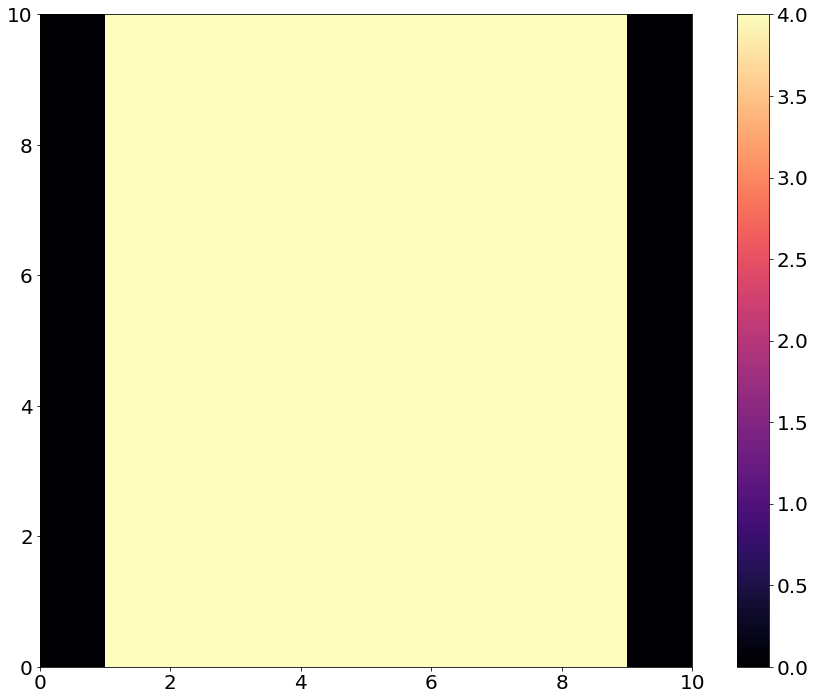

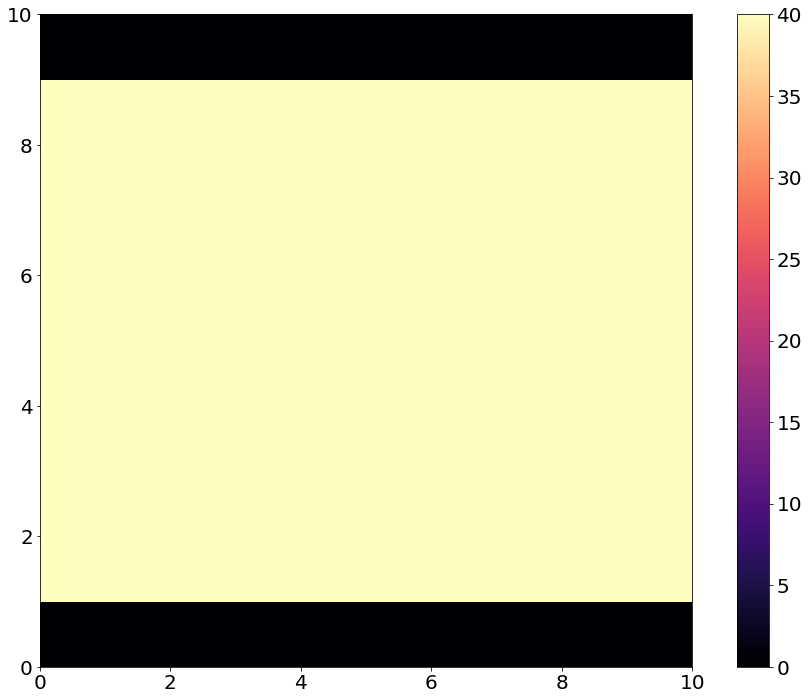

In [1200]:
Ptest = np.arange(100, dtype=float).reshape([10,10])
PtestX, PtestY = gradP(Ptest)

print(Ptest)
print(PtestX)
print(PtestY)

fig, ax = plt.subplots()
asc = ax.pcolormesh(PtestX, cmap = cm, vmin=0.0)
ax.set_aspect('equal', 'box')
fig.colorbar(asc, orientation='vertical')

fig, ax = plt.subplots()
asc = ax.pcolormesh(PtestY, cmap = cm, vmin=0.0)
ax.set_aspect('equal', 'box')
fig.colorbar(asc, orientation='vertical')



In [1201]:
Ptest0 = np.zeros((5,5))
Ptest0[4,2] = 1
Ptest0X, Ptest0Y = gradP(Ptest0)
print(Ptest0X)
print(Ptest0Y)

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  2.  0. -2.  0.]]
[[ 0.  0. -2.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


In [1202]:
convtestFilter1 = np.array([[0,0,-0.5]])
convtestFilter2 = np.array([[0.5,0,0]])
Ptest1 = convolve(Ptest, convtestFilter1, mode='wrap')
Ptest2 = convolve(Ptest, convtestFilter2, mode='wrap')
print(Ptest1)
print(Ptest2)

[[ -4.5   0.   -0.5  -1.   -1.5  -2.   -2.5  -3.   -3.5  -4. ]
 [ -9.5  -5.   -5.5  -6.   -6.5  -7.   -7.5  -8.   -8.5  -9. ]
 [-14.5 -10.  -10.5 -11.  -11.5 -12.  -12.5 -13.  -13.5 -14. ]
 [-19.5 -15.  -15.5 -16.  -16.5 -17.  -17.5 -18.  -18.5 -19. ]
 [-24.5 -20.  -20.5 -21.  -21.5 -22.  -22.5 -23.  -23.5 -24. ]
 [-29.5 -25.  -25.5 -26.  -26.5 -27.  -27.5 -28.  -28.5 -29. ]
 [-34.5 -30.  -30.5 -31.  -31.5 -32.  -32.5 -33.  -33.5 -34. ]
 [-39.5 -35.  -35.5 -36.  -36.5 -37.  -37.5 -38.  -38.5 -39. ]
 [-44.5 -40.  -40.5 -41.  -41.5 -42.  -42.5 -43.  -43.5 -44. ]
 [-49.5 -45.  -45.5 -46.  -46.5 -47.  -47.5 -48.  -48.5 -49. ]]
[[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  0. ]
 [ 5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5  5. ]
 [10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 10. ]
 [15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 15. ]
 [20.5 21.  21.5 22.  22.5 23.  23.5 24.  24.5 20. ]
 [25.5 26.  26.5 27.  27.5 28.  28.5 29.  29.5 25. ]
 [30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 30. 

In [1203]:
#x0 = rng0.random(N_particle) * Lx
#y0 = rng0.random(N_particle) * Ly
x0 = np.array([7.1, 8.1])
y0 = np.array([7.1, 8.1])
theta0 = (rng0.random(N_particle)*2 - 1)*np.pi
P0 = np.zeros([Nx, Ny], dtype=float)
#P0 = np.linspace(0, 10, Nx*Ny, dtype=float).reshape(Ny, Nx)

#P0[int(1.5/xyscale), int(1.5/xyscale)] = 1/(xyscale**2)

z0 = np.concatenate((x0, y0, theta0, P0.flatten()), 0)

sol = solve_ivp(dictySortToy, t_span, z0, t_eval=t_eval, max_step=max_step)

print(sol)

/tmp/ipykernel_6797/2702197700.py:29: RuntimeWarning: divide by zero encountered in true_divide
  Radr6 = ((Ra/dr) * flg_close)**6
/tmp/ipykernel_6797/2702197700.py:29: RuntimeWarning: invalid value encountered in multiply
  Radr6 = ((Ra/dr) * flg_close)**6


  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 60014
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
 t_events: None
        y: array([[7.10000000e+00, 7.56671527e+00, 9.02832100e+00, ...,
        1.12470835e+01, 9.71276003e+00, 8.15954801e+00],
       [8.10000000e+00, 7.16661834e+00, 8.53562199e+00, ...,
        1.22873361e+01, 1.06661006e+01, 8.96375824e+00],
       [7.10000000e+00, 9.01492248e+00, 1.03599170e+01, ...,
        1.13683584e+01, 1.00855544e+01, 8.82561814e+00],
       ...,
       [0.00000000e+00, 3.03287579e-03, 1.53419897e-02, ...,
        7.88659004e-02, 4.83820352e-02, 3.30151424e-02],
       [0.00000000e+00, 3.02605803e-03, 1.52401190e-02, ...,
        7.57173505e-02, 4.66388814e-02, 3.21096776e-02],
       [0.00000000e+00, 3.06084244e-03, 1.52429050e-02, ...,
        7.25688926e-02, 4.49466048e-02, 3.12657733e-02]])
 y_event

In [1204]:
t = 0

cm = plt.get_cmap("magma")

plt.rcParams['font.size'] = 20

qcolors = ['k', 'w']

x_plot, y_plot = np.meshgrid(np.arange(0,Nx)*xyscale, np.arange(0,Ny)*xyscale)

@interact(t=(0, Nt-1))
def f(t):
    x, y, theta, P = np.split(sol.y[:, t], [N_particle, N_particle*2, N_particle*3])
    P = P.reshape(Ny, Nx)

    if periodic:
      x = x % Lx
      y = y % Ly

    u = np.cos(theta)
    v = np.sin(theta)

    fig,(ax) = plt.subplots(1,1)
    plt.title("polarity, cAMP; t = " + str(t_eval[t]))
    asc = plt.pcolormesh(x_plot, y_plot, P, cmap = cm, vmin=0.0)
    for i in range(N_particleS.size):
      flg_i = Particle_typeLst==i
      plt.quiver(x[flg_i], y[flg_i], u[flg_i], v[flg_i], color=qcolors[i], angles='xy', pivot='mid')
    plt.figure(figsize=(1,1))
    ax.set_xlim([-2*xyscale, (Nx+2)*xyscale])
    ax.set_ylim([-2*xyscale, (Ny+2)*xyscale])
    ax.set_aspect('equal', 'box')
    fig.colorbar(asc, orientation='vertical')
 

interactive(children=(IntSlider(value=5, description='t', max=10), Output()), _dom_classes=('widget-interact',…

In [1205]:
now = datetime.datetime.now()
savedir = './dictyToy_DiffusionCheck_' + now.strftime('%Y%m%d_%H%M%S')
os.makedirs(savedir, exist_ok=True)

np.savez(os.path.join(savedir, 'params.npz'),
         t_span = t_span, Nt = Nt, t_eval = t_eval, max_step=max_step,
         alphas = alphas, betas = betas, xis = xis, etas = etas,
         Ra = Ra, Rt = Rt, Dp = Dp, a0 = a0, b0 = b0,
         N_particleS = N_particleS, Nx = Nx, Ny = Ny, xyscale = xyscale, periodic = periodic, #interp_method = interp_method,
         flg_noiseVM = flg_noiseVM, noiseVM = noiseVM, noiseVM_step = noiseVM_step, SEED = SEED, qcolors = qcolors)

loaddir = savedir
params = np.load(loaddir+'/params.npz', allow_pickle=True)

txtstring = []
for k in params.files:
    txtstring.append("{} = {}".format(k, params[k]))

print(*txtstring, sep="\n", file=codecs.open(loaddir+'/params.txt', 'w', 'utf-8'))

In [1206]:
x, y, theta, P = np.split(sol.y, [N_particle, N_particle*2, N_particle*3], axis=0)
P = P.reshape(Ny, Nx, Nt)

np.savez(os.path.join(savedir, 'results.npz'), x=x, y=y, theta=theta, P=P)

In [1207]:
def Gchems(x, y, P):
    
    Px, Py = gradP(P)
    if periodic:
        #Px = sobel(P, axis=1, mode='wrap')/(8*xyscale)
        #Py = sobel(P, axis=0, mode='wrap')/(8*xyscale)
        x = x % Lx
        y = y % Ly
        xy = np.concatenate((np.expand_dims(x, 0), np.expand_dims(y, 0)), 0)
        Px_interp = map_coordinates(Px, xy, mode='grid-wrap')
        Py_interp = map_coordinates(Py, xy, mode='grid-wrap')

    else:
        #Px = sobel(P, axis=1, mode='nearest')/(8*xyscale)
        #Py = sobel(P, axis=0, mode='nearest')/(8*xyscale)
        xy = np.concatenate((np.expand_dims(x, 0), np.expand_dims(y, 0)), 0)
        Px_interp = map_coordinates(Px, xy, mode='nearest')
        Py_interp = map_coordinates(Py, xy, mode='nearest')


    #Gchem = Gchemotaxis(Px_interp, Py_interp, theta)

    #GchemY = GchemotaxisYukawa(x, y, theta)
    
    Gx, Gy = PxPyYukawa(x, y)
    
    return Px_interp, Py_interp, Gx, Gy

/tmp/ipykernel_6797/2702197700.py:59: RuntimeWarning: divide by zero encountered in true_divide
  Gmag = ((kappa_Yukawa/(2*np.pi))/dr) * -kn(1, kappa_Yukawa*dr)#spherical_kn(0, kappa_Yukawa*dr, derivative=True)
/tmp/ipykernel_6797/2702197700.py:61: RuntimeWarning: invalid value encountered in multiply
  Gx = np.nansum(Gmag * dx, axis=1)
/tmp/ipykernel_6797/2702197700.py:62: RuntimeWarning: invalid value encountered in multiply
  Gy = np.nansum(Gmag * dy, axis=1)


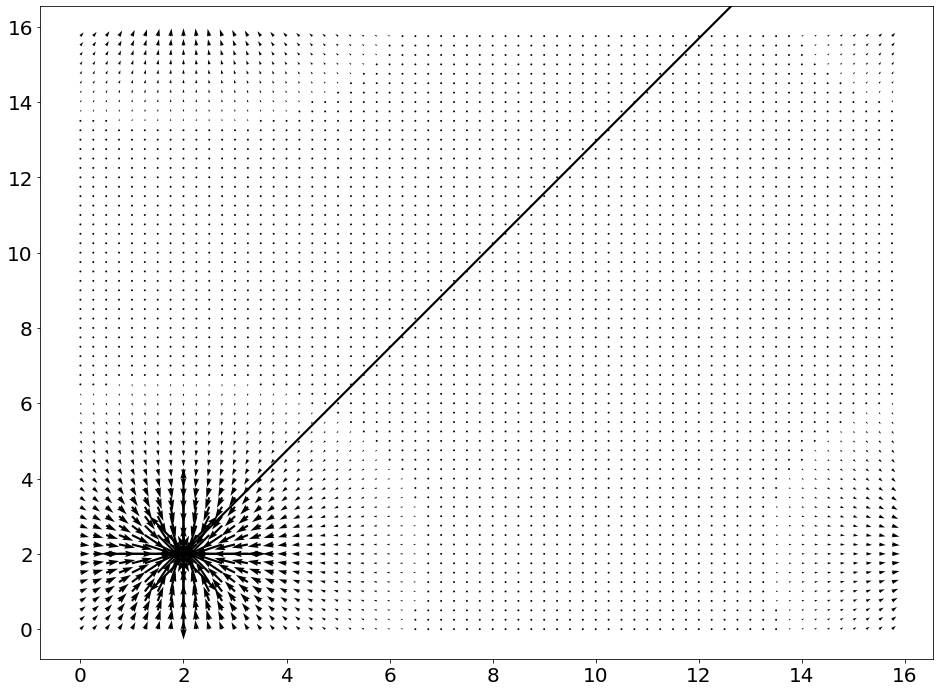

In [1208]:
x_range = np.arange(0,Nx)*xyscale
y_range = np.arange(0,Ny)*xyscale

Gx_out = np.zeros_like(x_plot)
Gy_out = np.zeros_like(y_plot)

for ix, x0 in enumerate(x_range):
    for iy, y0 in enumerate(y_range):
        x_in = np.array([x0, 2.0001])
        y_in = np.array([y0, 2.0001])
        Px, Py = PxPyYukawa(x_in, y_in)
        Gx_out[iy, ix], Gy_out[iy, ix] = Px[0], Py[0]

Gx_out[Gx_out>1e2] = 1e2
Gy_out[Gy_out>1e2] = 1e2
        
plt.quiver(x_plot, y_plot, Gx_out, Gy_out)


In [1209]:
print(Gy_out)

[[0.02575413 0.03025159 0.03532644 ... 0.01571098 0.01852873 0.02185712]
 [0.02647033 0.03170559 0.03784303 ... 0.01543995 0.01844467 0.02208378]
 [0.02649527 0.03243719 0.03971705 ... 0.01474    0.01784216 0.02169883]
 ...
 [0.02160231 0.02426227 0.02702251 ... 0.01476269 0.0168254  0.01911056]
 [0.02316069 0.02634908 0.02973615 ... 0.01529587 0.01761767 0.02024024]
 [0.02458912 0.02839306 0.03254752 ... 0.01563604 0.01821629 0.02119385]]


In [1210]:
np.isnan(Gy_out).sum()

0

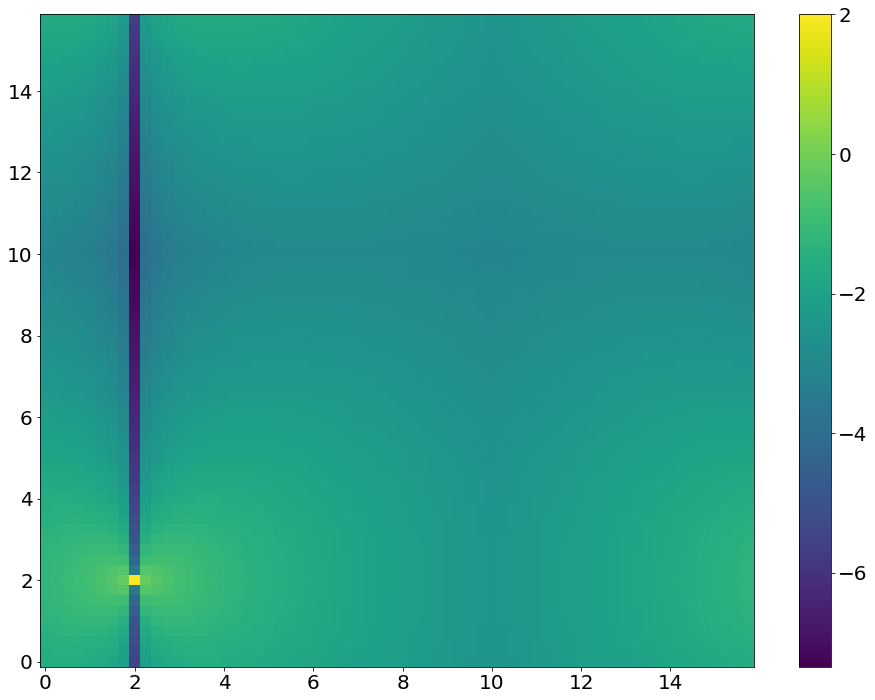

In [1211]:
asc = plt.pcolormesh(x_plot, y_plot, np.log10(abs(Gx_out)))
plt.colorbar(asc)

In [1212]:
PxDirect = np.zeros_like(theta)
PyDirect = np.zeros_like(theta)
PxYukawa = np.zeros_like(theta)
PyYukawa = np.zeros_like(theta)

for t in range(Nt):
    PxDirect[..., t], PyDirect[..., t], PxYukawa[..., t], PyYukawa[..., t] = Gchems(x[:,t], y[:,t], P[..., t])

/tmp/ipykernel_6797/2702197700.py:59: RuntimeWarning: divide by zero encountered in true_divide
  Gmag = ((kappa_Yukawa/(2*np.pi))/dr) * -kn(1, kappa_Yukawa*dr)#spherical_kn(0, kappa_Yukawa*dr, derivative=True)
/tmp/ipykernel_6797/2702197700.py:61: RuntimeWarning: invalid value encountered in multiply
  Gx = np.nansum(Gmag * dx, axis=1)
/tmp/ipykernel_6797/2702197700.py:62: RuntimeWarning: invalid value encountered in multiply
  Gy = np.nansum(Gmag * dy, axis=1)


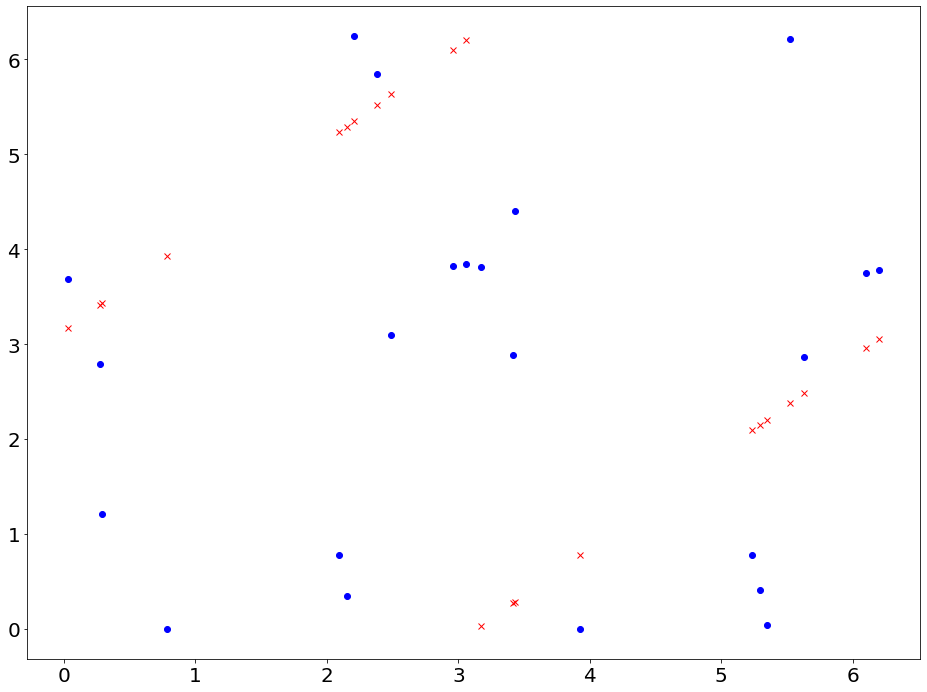

In [1213]:
phi_PDirect = np.arctan2(PyDirect, PxDirect) % (2*np.pi)
phi_PYukawa = np.arctan2(PyYukawa, PxYukawa) % (2*np.pi)
phi_dr = np.zeros_like(phi_PDirect)
dx = x[0, :] - x[1, :]
dy = y[0, :] - y[1, :]
if periodic:
    dx = dx % Lx
    dx[dx>Lx/2] = dx[dx>Lx/2] - Lx
    dy = dy % Ly
    dy[dy>Ly/2] = dy[dy>Ly/2] - Ly
phi_dr[0, :] = np.arctan2(dy, dx) % (2*np.pi)
phi_dr[1, :] = np.arctan2(-dy, -dx) % (2*np.pi)

fig, ax = plt.subplots()
ax.plot(phi_dr.flatten(), phi_PDirect.flatten(), 'bo')
ax.plot(phi_dr.flatten(), phi_PYukawa.flatten(), 'rx')
#ax.set_ylim(-0.02, 0.02)

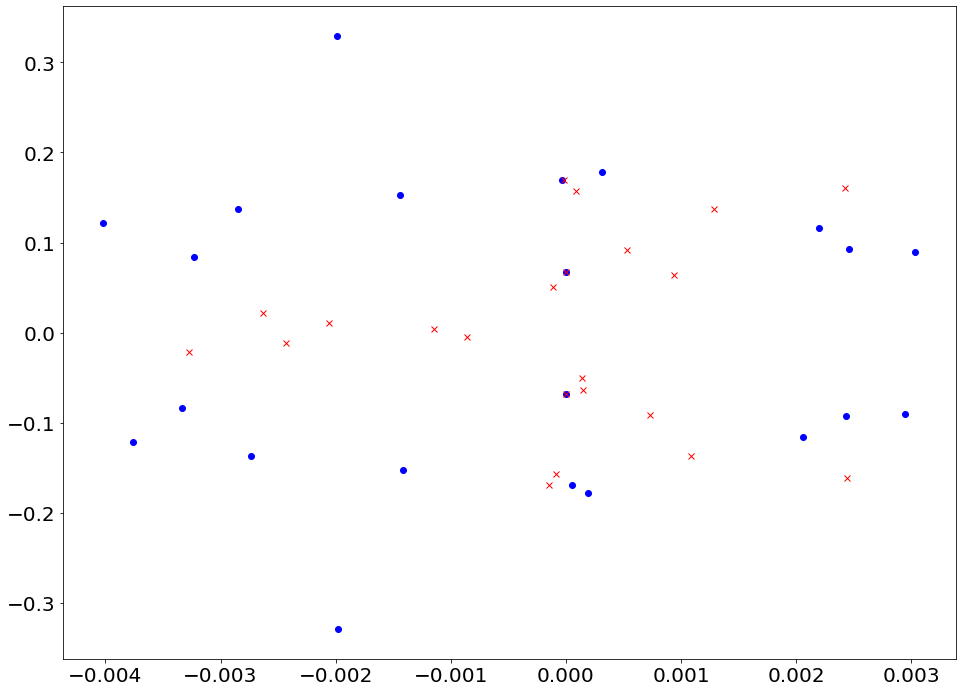

In [1214]:
fig, ax = plt.subplots()
ax.plot(PxDirect.flatten(), PxYukawa.flatten(), 'bo')
ax.plot(PyDirect.flatten(), PyYukawa.flatten(), 'rx')
#ax.set_ylim(-0.02, 0.02)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-4.01770129e-03, -3.90019222e-03, -3.78268316e-03, -3.66517409e-03,
        -3.54766502e-03, -3.43015595e-03, -3.31264689e-03, -3.19513782e-03,
        -3.07762875e-03, -2.96011968e-03, -2.84261062e-03, -2.72510155e-03,
        -2.60759248e-03, -2.49008341e-03, -2.37257435e-03, -2.25506528e-03,
        -2.13755621e-03, -2.02004714e-03, -1.90253808e-03, -1.78502901e-03,
        -1.66751994e-03, -1.55001087e-03, -1.43250181e-03, -1.31499274e-03,
        -1.19748367e-03, -1.07997461e-03, -9.62465538e-04, -8.44956470e-04,
        -7.27447403e-04, -6.09938336e-04, -4.92429268e-04, -3.74920201e-04,
        -2.57411133e-04, -1.39902066e-04, -2.23929984e-05,  9.51160690e-05,
         2.12625136e-04,  3.30134204e-04,  4.47643271e-04,  5.65152

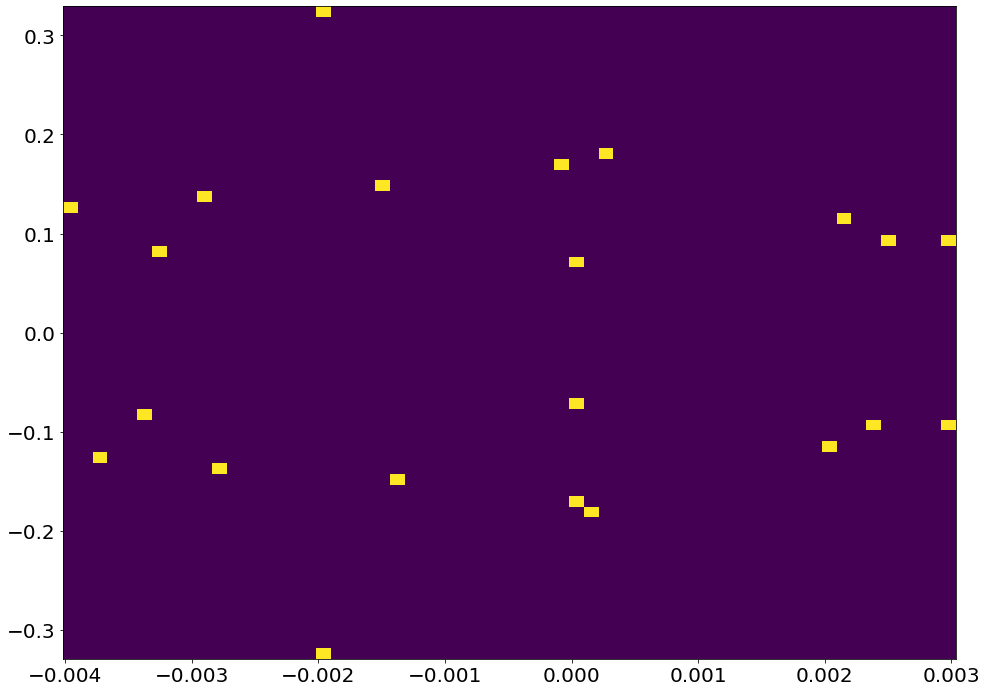

In [1215]:
plt.hist2d(PxDirect.flatten(), PxYukawa.flatten(), 60)#, [[-0.0003, 0.0003], [-0.0003, 0.0003]])

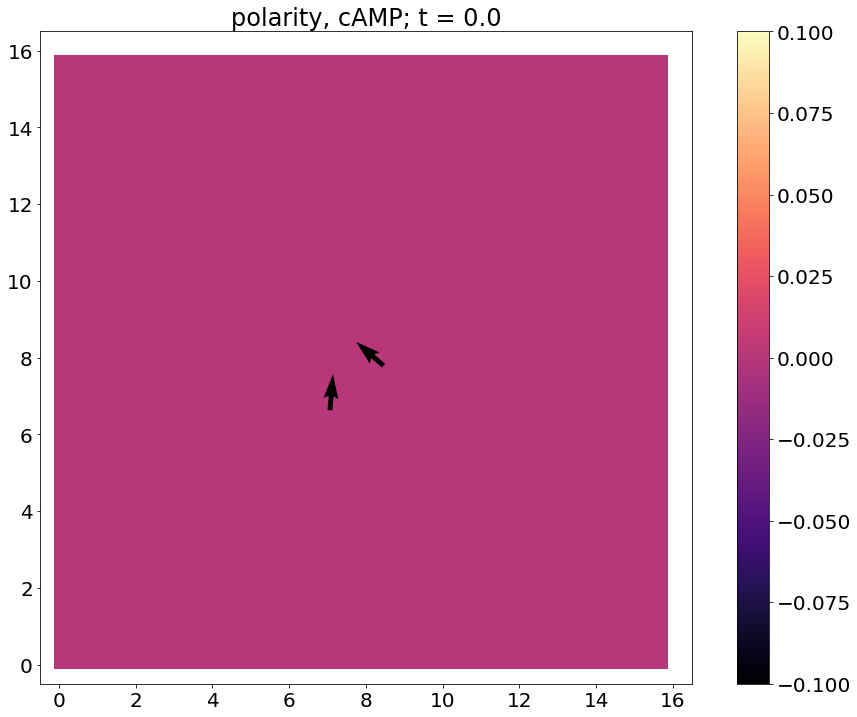

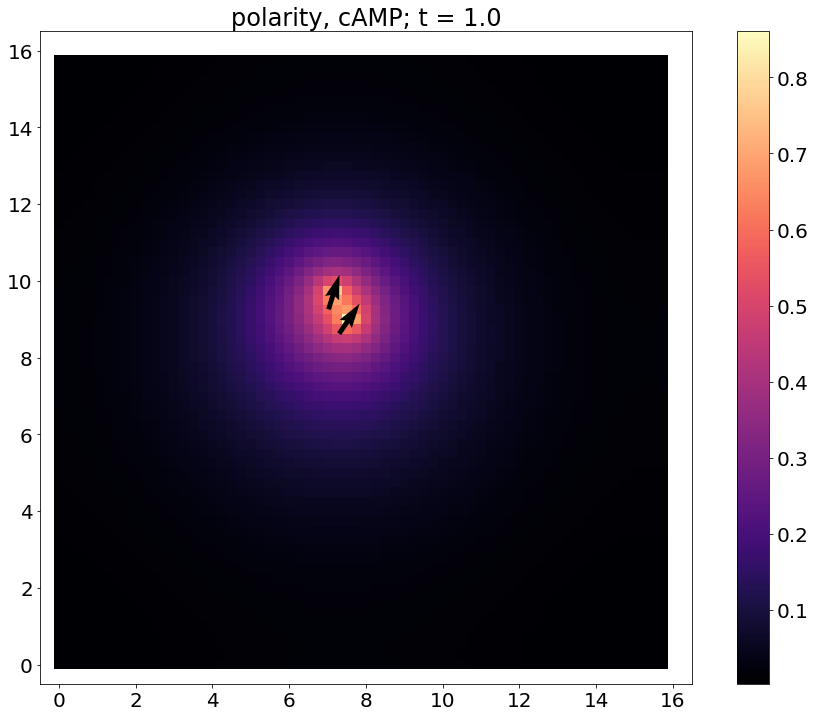

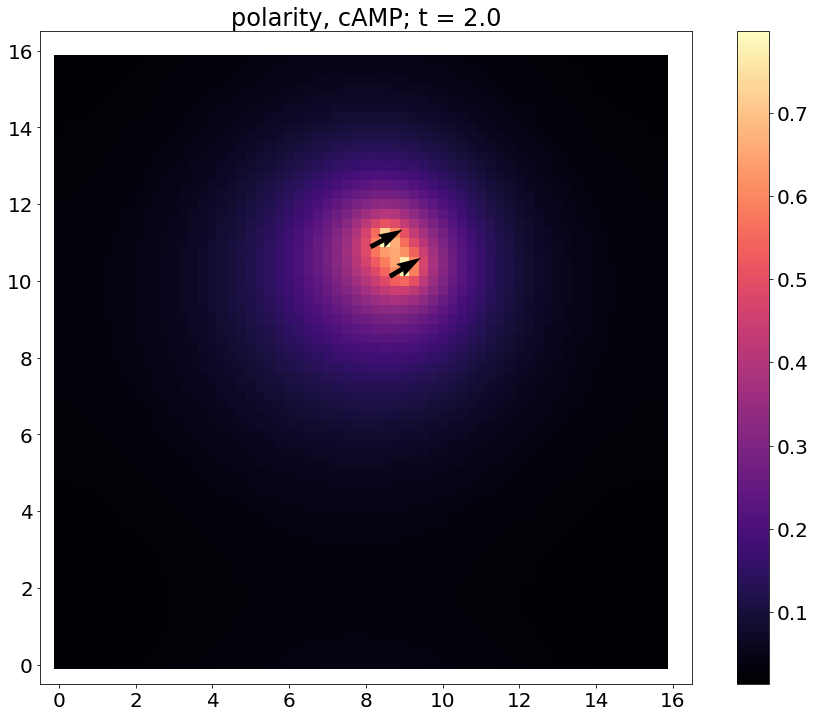

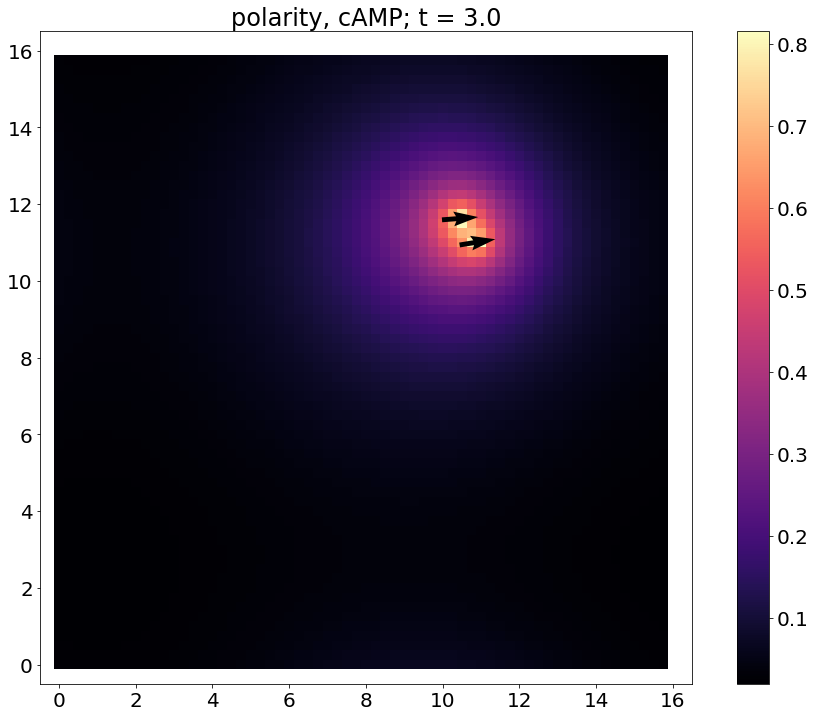

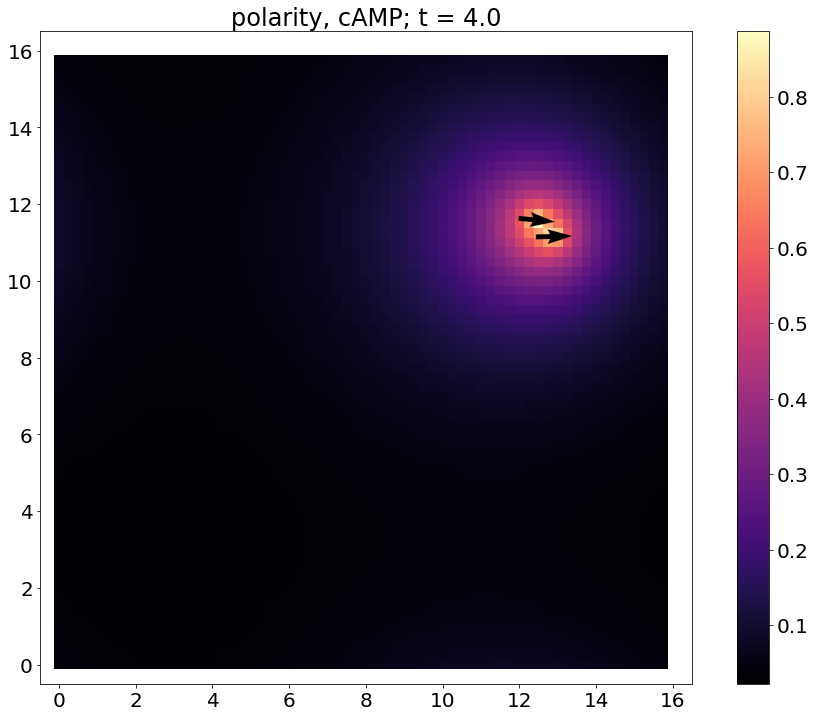

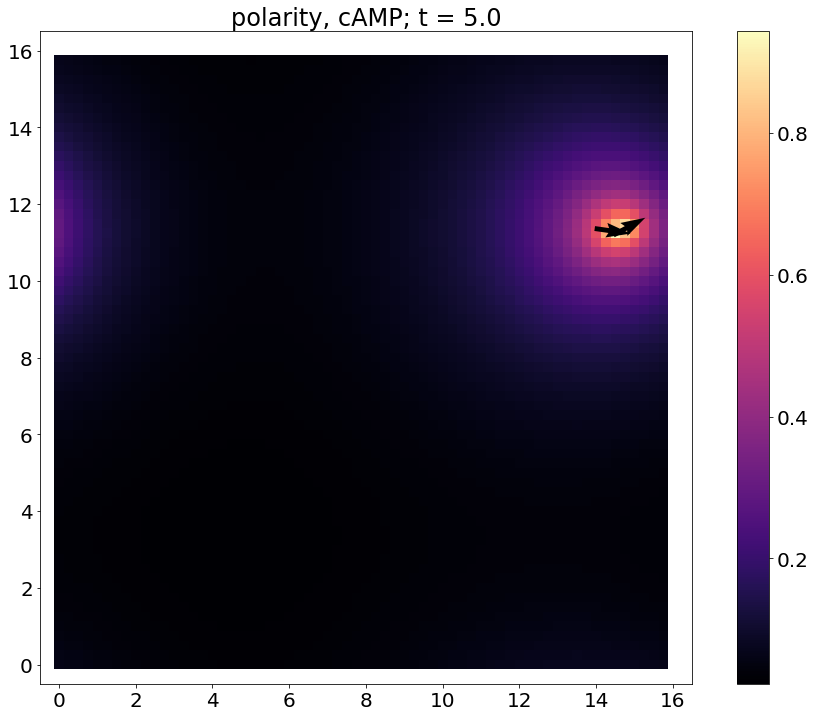

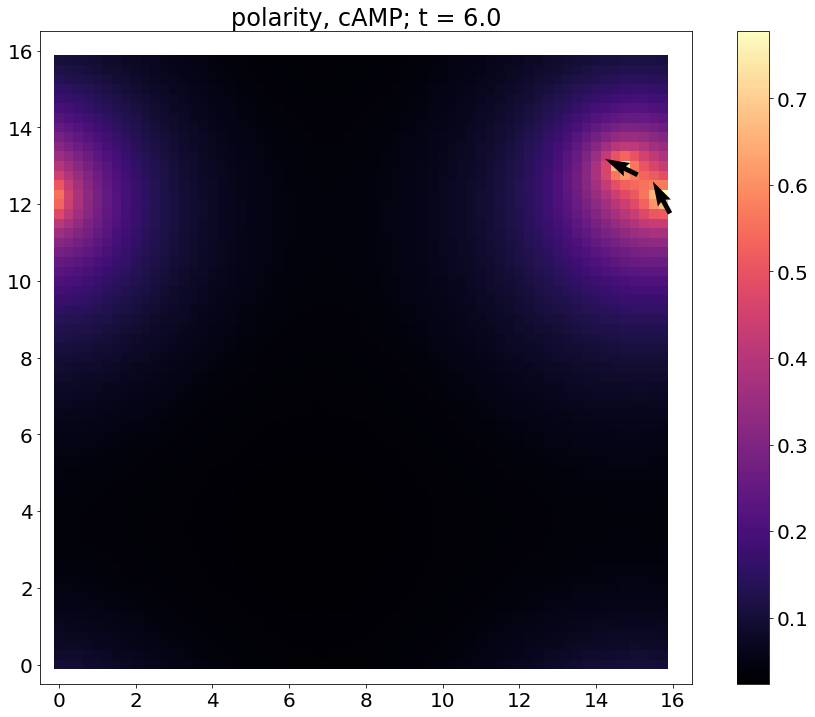

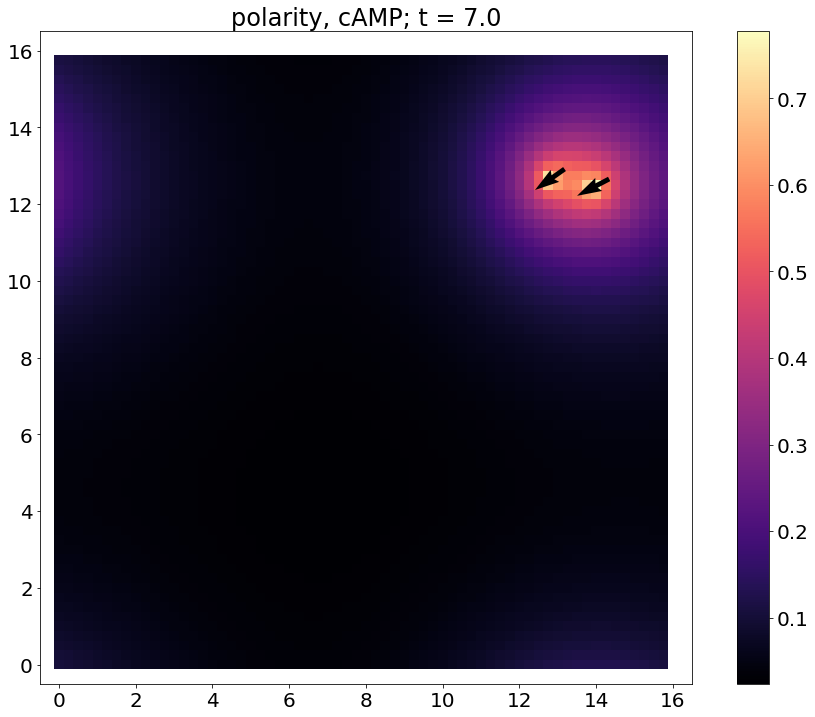

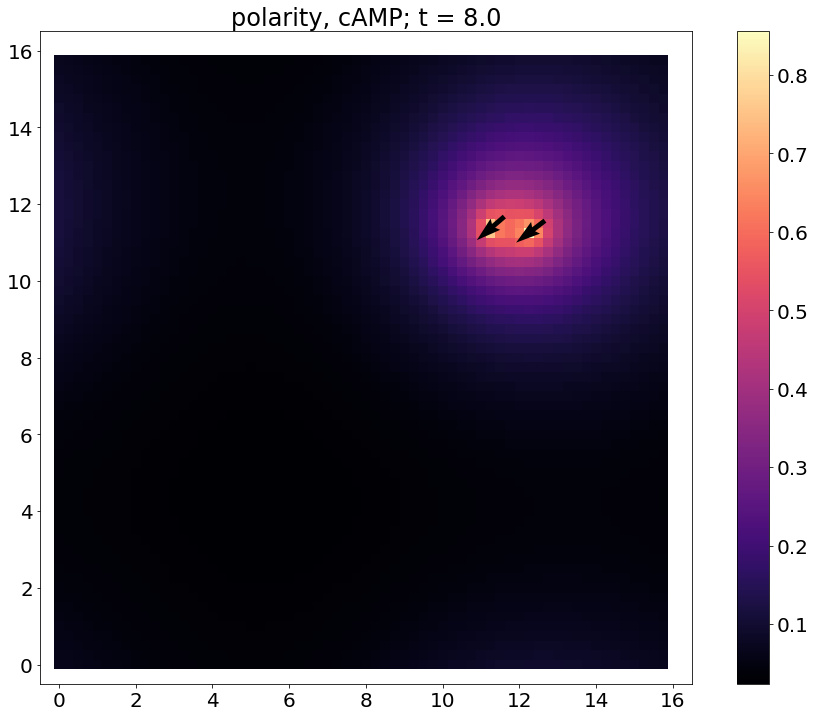

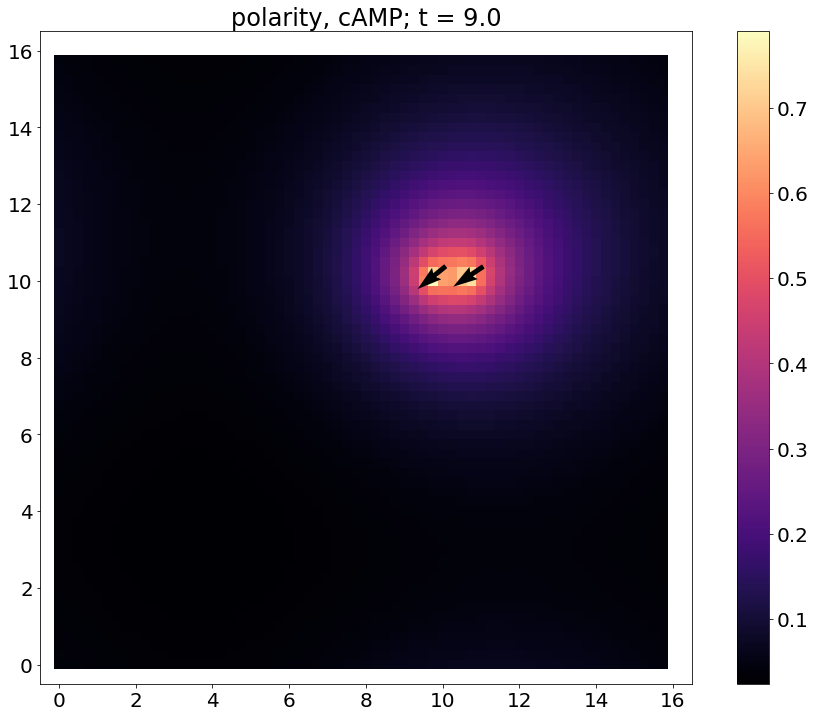

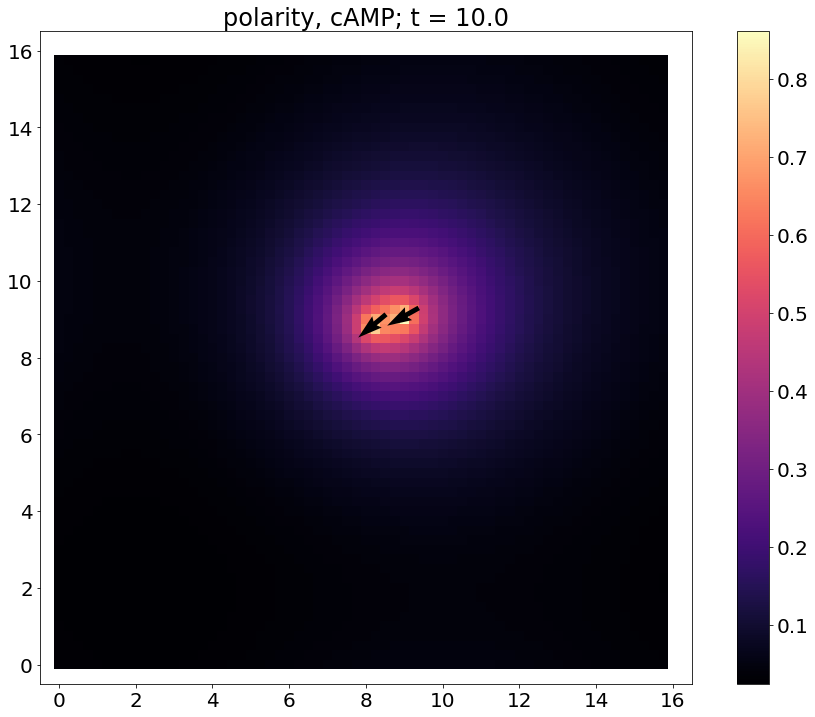

In [1216]:
plt.rcParams['figure.figsize'] = [16, 12]

cm = plt.get_cmap("magma")


for t in range(Nt):
    x, y, theta, P = np.split(sol.y[:, t], [N_particle, N_particle*2, N_particle*3])
    P = P.reshape(Ny, Nx)

    if periodic:
      x = x % Lx
      y = y % Ly

    u = np.cos(theta)
    v = np.sin(theta)

    fig,(ax) = plt.subplots(1,1)
    plt.title("polarity, cAMP; t = " + str(t_eval[t]))
    asc = plt.pcolormesh(x_plot, y_plot, P, cmap = cm)
    for i in range(N_particleS.size):
        flg_i = Particle_typeLst==i
        plt.quiver(x[flg_i], y[flg_i], u[flg_i], v[flg_i], color=qcolors[i], angles='xy', pivot='mid')
    plt.figure(figsize=(1,1))
    ax.set_xlim([-2*xyscale, (Nx+2)*xyscale])
    ax.set_ylim([-2*xyscale, (Ny+2)*xyscale])
    ax.set_aspect('equal', 'box')
    fig.colorbar(asc, orientation='vertical')
    
    fig.savefig(os.path.join(savedir, format(t, '03d'))+'.png', format='png')
    
    plt.clf()
    plt.close()

In [1217]:
def Pyukawa_field(x,y,xg,yg):
    grid_shape = xg.shape
    dx = np.expand_dims(xg.flatten(), 1) - np.expand_dims(x, 0) # dim0=target, dim1=neighbor
    dy = np.expand_dims(yg.flatten(), 1) - np.expand_dims(y, 0)

    if periodic:
        dx = dx % Lx
        dx[dx>Lx/2] = dx[dx>Lx/2] - Lx
        dy = dy % Ly
        dy[dy>Ly/2] = dy[dy>Ly/2] - Ly

    dr = (dx**2 + dy**2)**0.5
    G = kn(0, kappa_Yukawa*dr) /(2*np.pi)
    #Gmag = np.exp(-kappa_Yukawa*dr) * (-kappa_Yukawa*dr - 1)/(dr**3)
    #Gx = np.nansum(Gmag * dx, axis=1)
    G = np.nansum(G, axis=1)
    return A_Yukawa*G.reshape(grid_shape)

In [1218]:
cm = plt.get_cmap("magma")

savedir_Mac = savedir + '/MacDonald'
os.makedirs(savedir_Mac, exist_ok=True)

for t in range(Nt):
    x, y, theta, P = np.split(sol.y[:, t], [N_particle, N_particle*2, N_particle*3])
    P = P.reshape(Ny, Nx)
    Pyukawa = Pyukawa_field(x, y, x_plot, y_plot)
    
    fig,(ax) = plt.subplots(1,1)
    plt.title("cAMP Macdonald approximated; t = " + str(t_eval[t]))
    asc = plt.pcolormesh(x_plot, y_plot, Pyukawa, cmap = cm)
    ax.set_xlim([-2*xyscale, (Nx+2)*xyscale])
    ax.set_ylim([-2*xyscale, (Ny+2)*xyscale])
    ax.set_aspect('equal', 'box')
    fig.colorbar(asc, orientation='vertical')
    
    fig.savefig(os.path.join(savedir_Mac, format(t, '03d'))+'.png', format='png')
    
    plt.clf()
    plt.close()
    
    fig,(ax) = plt.subplots(1,1)
    plt.title("cAMP Macdonald approximated / PDE; t = " + str(t_eval[t]))
    asc = plt.pcolormesh(x_plot, y_plot, Pyukawa/P, cmap = cm)
    ax.set_xlim([-2*xyscale, (Nx+2)*xyscale])
    ax.set_ylim([-2*xyscale, (Ny+2)*xyscale])
    ax.set_aspect('equal', 'box')
    fig.colorbar(asc, orientation='vertical')
    
    fig.savefig(os.path.join(savedir_Mac, 'ratio'+format(t, '03d'))+'.png', format='png')
    
    plt.clf()
    plt.close()
    
    

/tmp/ipykernel_6797/778788186.py:26: RuntimeWarning: divide by zero encountered in true_divide
  asc = plt.pcolormesh(x_plot, y_plot, Pyukawa/P, cmap = cm)


In [1219]:
print(np.sum(P)*(xyscale**2))
print(np.sum(Pyukawa)*(xyscale**2))
print(N_particle*a0/b0)

19.99909200140475
17.148693184413986
20.0


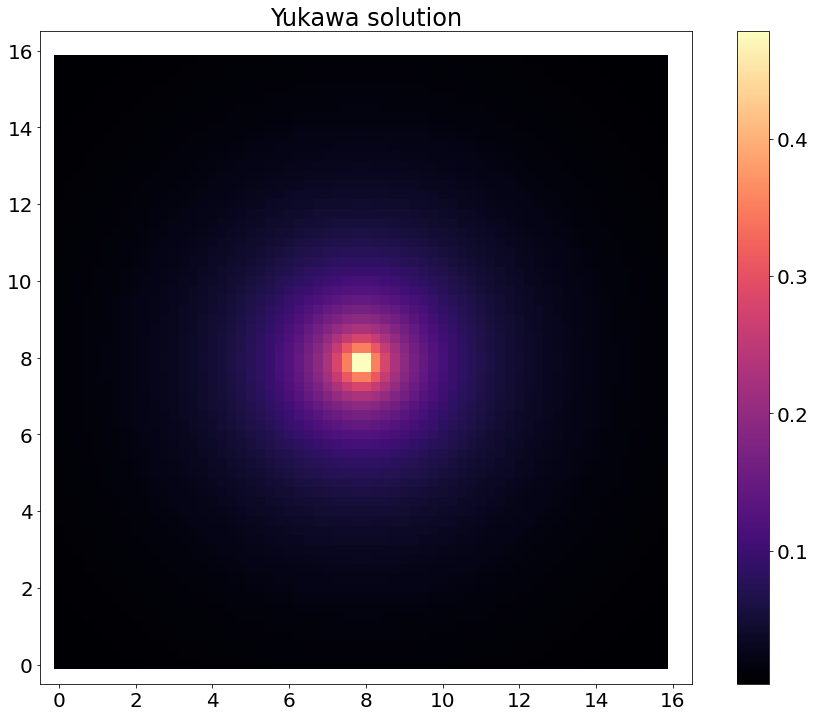

In [1220]:
Pyukawa0 = Pyukawa_field(np.array([np.mean(x_plot)]), np.array([np.mean(y_plot)]), x_plot, y_plot)

fig,(ax) = plt.subplots(1,1)
plt.title("Yukawa solution")
asc = plt.pcolormesh(x_plot, y_plot, Pyukawa0/A_Yukawa, cmap = cm)
ax.set_xlim([-2*xyscale, (Nx+2)*xyscale])
ax.set_ylim([-2*xyscale, (Ny+2)*xyscale])
ax.set_aspect('equal', 'box')
fig.colorbar(asc, orientation='vertical')

In [1221]:
print(np.sum(Pyukawa0)*(xyscale**2)/A_Yukawa)

8.57215890878965


In [1222]:
def Pyukawa_conv(x,y,xg,yg):
    grid_shape = xg.shape
    
    xc = np.mean(xg.flatten())
    yc = np.mean(yg.flatten())
    
    r = ((xg - xc)**2 + (yg - yc)**2)**0.5
    
    #rflg = r<=4
    
    #r = r[rflg]
    
    G = kn(0, kappa_Yukawa*r)/(2*np.pi)
    
    (xA, xB) = np.divmod(x, xyscale)
    (yA, yB) = np.divmod(y, xyscale)
    xB = xB / xyscale
    yB = yB / xyscale
    A = np.concatenate((np.expand_dims(yA, 1), np.expand_dims(xA, 1)), 1)
    A = np.concatenate((A, A + np.array([[0,1]]), A + np.array([[1,0]]), A + np.array([[1,1]])), 0)
    A[:,0] = A[:,0] % Ny
    A[:,1] = A[:,1] % Nx
    B = np.concatenate(((1-yB)*(1-xB), (1-yB)*xB, yB*(1-xB), yB*xB), 0)
    Pplus = coo_matrix((B, (A[:,0], A[:,1])), shape=P.shape, dtype=float).toarray()

    if periodic:
        GP = convolve(Pplus, G, mode='wrap')
    else:
        GP = convolve(Pplus, G, mode='constant', cval=0)

    return A_Yukawa*GP



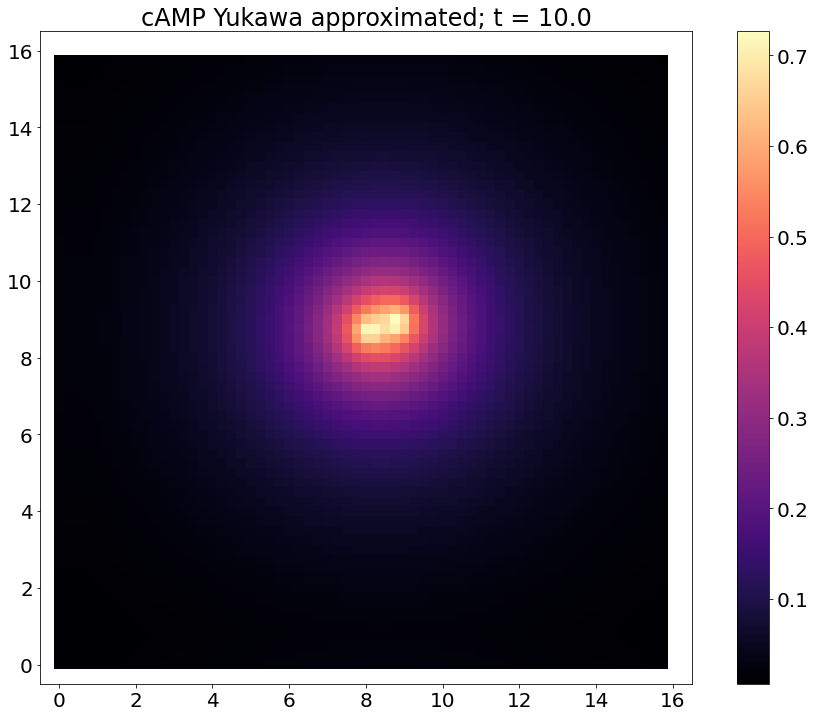

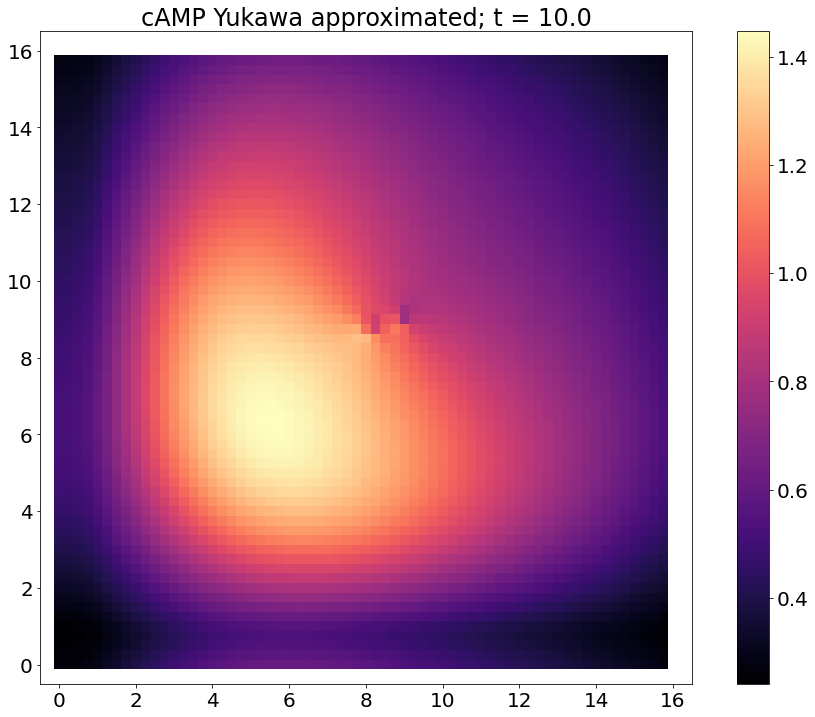

In [1223]:
for t in [Nt-1]:#range(Nt):
    x, y, theta, P = np.split(sol.y[:, t], [N_particle, N_particle*2, N_particle*3])
    P = P.reshape(Ny, Nx)
    Pyukawa = Pyukawa_conv(x, y, x_plot, y_plot)
    
    fig,(ax) = plt.subplots(1,1)
    plt.title("cAMP Yukawa approximated; t = " + str(t_eval[t]))
    asc = plt.pcolormesh(x_plot, y_plot, Pyukawa, cmap = cm)
    ax.set_xlim([-2*xyscale, (Nx+2)*xyscale])
    ax.set_ylim([-2*xyscale, (Ny+2)*xyscale])
    ax.set_aspect('equal', 'box')
    fig.colorbar(asc, orientation='vertical')
    
    fig,(ax) = plt.subplots(1,1)
    plt.title("cAMP Yukawa approximated; t = " + str(t_eval[t]))
    asc = plt.pcolormesh(x_plot, y_plot, Pyukawa/P, cmap = cm)
    ax.set_xlim([-2*xyscale, (Nx+2)*xyscale])
    ax.set_ylim([-2*xyscale, (Ny+2)*xyscale])
    ax.set_aspect('equal', 'box')
    fig.colorbar(asc, orientation='vertical')
    

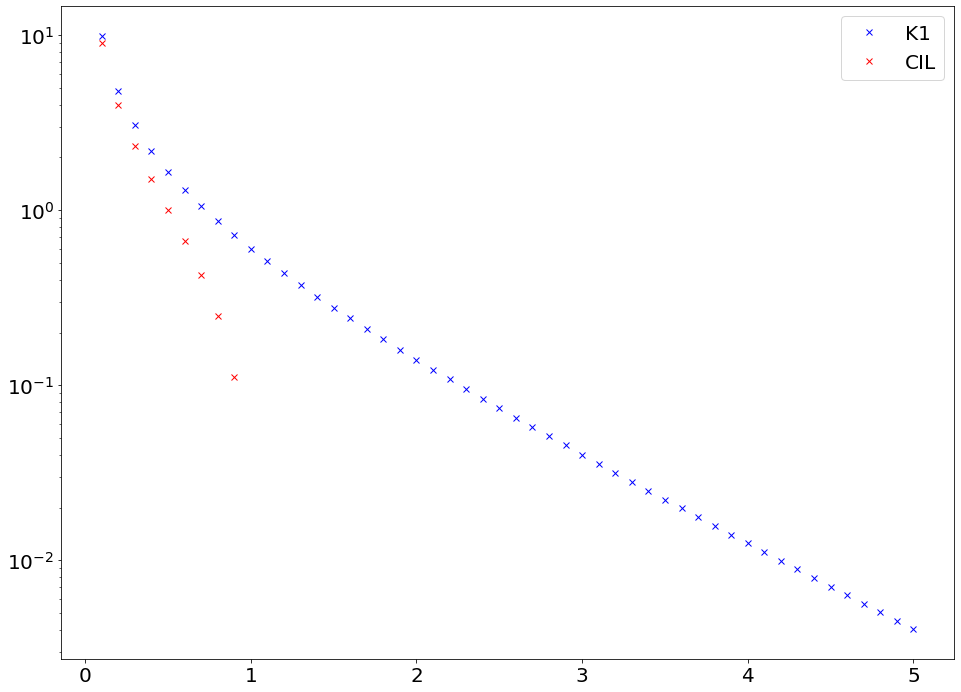

In [1229]:
K1_test = np.arange(0.1, 5.1, 0.1)
K1_out = kn(1, K1_test)
cil_out = 1/K1_test - 1
fig, ax = plt.subplots()
ax.plot(K1_test, K1_out, 'bx', label='K1')
ax.semilogy(K1_test, cil_out, 'rx', label='CIL')
ax.legend()